### Article's Code
You can find it in <a href='https://github.com/wuningxi/tBERT'>this</a> Github.


### Prerequisites:

In [1]:
!pip install --quiet transformers

     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 101 kB 10.0 MB/s 
     |████████████████████████████████| 6.6 MB 31.1 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 


### Imports:

In [2]:
import gc
import random
import warnings


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


import torch
from torch import nn
import torch.optim as optim
from torch.cuda import empty_cache
from torch.utils.data import DataLoader, random_split


from transformers import logging
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
from transformers import BertModel,BertTokenizer
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available


from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report

from sklearn.utils import compute_class_weight
from tqdm import tqdm

import gensim, spacy
import gensim.corpora as corpora
from nltk.corpus import stopwords

import pandas as pd
import re
from tqdm import tqdm
import time

from collections import defaultdict
from google.colab import drive

##### Warnings & Verbose

In [3]:
warnings.filterwarnings("ignore") # general
logging.set_verbosity_error() # huggingface

##### Setup -  Natural Language Tool Kit 

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##### Setup - Google Drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/NLP/tBert-final-project/tBERT/

/content/drive/MyDrive/NLP/tBert-final-project/tBERT


In [7]:
!ls

BERT.ipynb	  lda_cv.ipynb		  tBERT_with_LDA.ipynb
data		  results		  tBERT_with_LDA_QOURA.ipynb
gensim-lda.ipynb  tBERT.jpg
lda_bert.ipynb	  tBERT_with_GSDMM.ipynb


In [8]:
SEED = 82

In [9]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(SEED)

## Dataset

##### Torch's Dataset

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        return x,y

    def __len__(self):
        return len(self.encodings)


class PairDataset(torch.utils.data.Dataset):
    def __init__(self, text1,text2,labels):
        self.text1  = text1
        self.text2  = text2
        self.labels = labels

    def __getitem__(self, idx):
        x1 = self.text1[idx]
        x2 = self.text2[idx]
        y = self.labels[idx]
        return x1,x2,y

    def __len__(self):
        return len(self.labels)

### MSRP


In [11]:
msrp_train = 'data/MSRP/MSRParaphraseCorpus/msr-para-train.tsv'
msrp_val   = 'data/MSRP/MSRParaphraseCorpus/msr-para-val.tsv'
msrp_test  = 'data/MSRP/MSRParaphraseCorpus/msr-para-test.tsv'

##### Create a dataframe

In [12]:
df_msrp_train = pd.read_csv(msrp_train, sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()
df_msrp_val   = pd.read_csv(msrp_val,   sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()
df_msrp_test  = pd.read_csv(msrp_test,  sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()

df_msrp_train.shape,df_msrp_val.shape,df_msrp_test.shape


((3461, 3), (480, 3), (1641, 3))

In [13]:
df_msrp_train.head()

,label,q1,q2
0,1,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...


In [14]:
df_msrp_test.head()

,label,q1,q2
0,1,"PCCW's chief operating officer, Mike Butcher, ...",Current Chief Operating Officer Mike Butcher a...
1,1,The world's two largest automakers said their ...,Domestic sales at both GM and No. 2 Ford Motor...
2,1,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,0,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,0,The company didn't detail the costs of the rep...,But company officials expect the costs of the ...


##### Create PairDataset

In [15]:
dataset_msrp_train = PairDataset(df_msrp_train.q1.values, df_msrp_train.q2.values, df_msrp_train.label.values)
dataset_msrp_val   = PairDataset(df_msrp_val.q1.values,   df_msrp_val.q2.values,   df_msrp_val.label.values)
dataset_msrp_test  = PairDataset(df_msrp_test.q1.values,  df_msrp_test.q2.values,  df_msrp_test.label.values)

##### Distribution - Traget Labels  


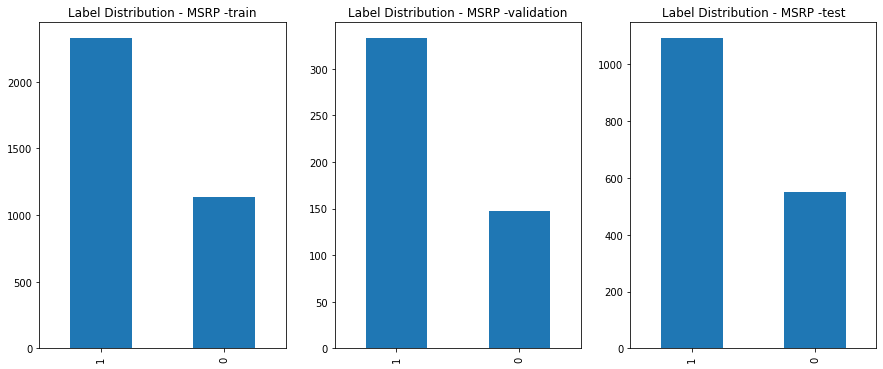

In [16]:
d = {'train':df_msrp_train,'validation':df_msrp_val,'test':df_msrp_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution - MSRP -' + k)

It is easy to see that there are twise as much "true" then "false" - as it was proposed in the article, will use the F1 parameter to evaluate our resulted model.
<br><br>
<br><br>

## Models - Setup DL models

#### Model - BERT


























































































































































































#### Setup Trainer

In [17]:
T_SEED=SEED

In [18]:
T_MAX_LEN = 10

In [19]:
MAX_LEN_BERT = 50

In [20]:
n_topics = [1,5,10,20,60,70,75,80,85,90,100]

In [21]:
# BERT_MODEL_NAME = "google/bert_uncased_L-12_H-768_A-12"
BERT_MODEL_NAME = "bert-base-uncased"

In [22]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [23]:
def preprocessing(sentence):
  sentence = str(sentence).lower()                                            # lower latters
  words = word_tokenize(sentence)                                             # split into words
  words = [word for word in words if word.isalpha()]                          # remove punctuations
  words = [word for word in words if word not in stopwords.words('english')]  # remove stopwords
  words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2] == 'NN']    # keep nouns
  sentence = ' '.join(words)                                                  # combine words to a sentence
  return sentence
def preprocessAll(sentences):
  sentences = [preprocessing(sentence) for sentence in sentences]
  return sentences

def get_words_len_for_topics(topics):
  return 50

In [24]:
all_sentences = df_msrp_train.q1.values.tolist()
all_sentences.extend(df_msrp_train.q2.values.tolist())
all_sentences.extend(df_msrp_val.q1.values.tolist())
all_sentences.extend(df_msrp_val.q2.values.tolist())

In [25]:
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = stopwords.words('english')
# Add some extra words in it if required
stop_words.extend(['from', 'subject', 'use','pron'])

In [26]:
def clean_procedure(input_data):
  data = input_data

  ### Cleaning data

  # Remove Emails
  data = [re.sub('S*@S*s?', '', sent) for sent in data]
  # Remove new line characters and extra space
  data = [re.sub('s+', ' ', sent) for sent in data]
  # Remove single quotes
  data = [re.sub("'", "", sent) for sent in data]

  ### Lemmatization
  data_lemma = []
  for i, txt in enumerate(data):
      lis = []
      doc = nlp(txt)
      for token in doc:
          lis.append(token.lemma_)
      data_lemma.append(' '.join(lis))

  ### Tokenization and gensim stopword removal

  # You can look for all gensim stopwords by running -> 'gensim.parsing.preprocessing.STOPWORDS'

  # Function to tokenize
  # Also remove words whose length less than 3 (you can chang it)
  def tokenization_with_gen_stop(text):
      result=[]
      for token in gensim.utils.simple_preprocess(text) :
          if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
              result.append(token)

      return result

  ## Apply tokenization function
  data_words = []
  for i, txt in enumerate(data_lemma):
      data_words.append(tokenization_with_gen_stop(txt))

  ### NLTK Stopword removal (extra stopwords)

  _cleaned = []
  for i, word in enumerate(data_words):
      wrd = []
      for w in word:
          if w not in stop_words:
              wrd.append(w)
      _cleaned.append(wrd)
  mapped = dict()
  for i, words in enumerate(_cleaned):
    mapped[input_data[i]] = words
  return _cleaned, mapped

In [27]:
print('cleaning data...')
data_words_clean, mapped = clean_procedure(all_sentences)
# Create Dictionary
dictionary = corpora.Dictionary(data_words_clean)
# Print dictionary
print(dictionary.token2id)

## Create Term document frequency (corpus)
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in data_words_clean]

cleaning data...
{'accu': 0, 'amrozi': 1, 'brother': 2, 'deliberately': 3, 'evidence': 4, 'torte': 5, 'witne': 6, 'billion': 7, 'chain': 8, 'dominick': 9, 'elle': 10, 'safeway': 11, 'yucaipa': 12, 'adverti': 13, 'cargo': 14, 'ement': 15, 'internet': 16, 'june': 17, 'offer': 18, 'publi': 19, 'cent': 20, 'early': 21, 'hare': 22, 'high': 23, 'record': 24, 'exchange': 25, 'friday': 26, 'percent': 27, 'stock': 28, 'tock': 29, 'york': 30, 'drop': 31, 'period': 32, 'quarter': 33, 'revenue': 34, 'year': 35, 'gain': 36, 'weekly': 37, 'appeal': 38, 'court': 39, 'supreme': 40, 'tate': 41, 'compare': 42, 'million': 43, 'company': 44, 'ervice': 45, 'food': 46, 'growth': 47, 'long': 48, 'term': 49, 'trategy': 50, 'carry': 51, 'coach': 52, 'enger': 53, 'gyorgy': 54, 'head': 55, 'heizler': 56, 'local': 57, 'unit': 58, 'developer': 59, 'enior': 60, 'evangeli': 61, 'ident': 62, 'platform': 63, 'recently': 64, 'rudder': 65, 'vice': 66, 'allow': 67, 'chao': 68, 'cheme': 69, 'companie': 70, 'control': 71, 

In [28]:
BATCH_SIZE = 32

In [34]:
from transformers import AdamW
class myTrainer():
  def __init__(self,
               model,
               train_dataset, val_dataset,test_dataset,
               batch_size,
               epochs = 5, with_LDA = False, model_name = 'basemodel'):
    
    self.model = model
    self.epochs = epochs
    self.with_LDA = with_LDA
    self.model_name = str(model_name)

    self.criterion = nn.BCELoss()
    learningRate = 50 ** -5
    self.optimizer = AdamW(self.model.parameters(), lr=learningRate)
    self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    self.test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    self.loss_train = []
    self.loss_val = []

  def calculate_loss(self, true_y, predicted_y):
    label_tensor = true_y.type(torch.FloatTensor).unsqueeze(1).cuda()
    loss = self.criterion(predicted_y, label_tensor)
    return loss



  def train(self):
    min_valid_loss = np.inf
    
    # run on all epochs
    print(self.model_name + ': Training \t',end='')
    print('\n')
    for epoch in range(self.epochs):
      with tqdm(self.train_dataloader, unit="batch", leave=False) as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch+1} train step")
            if len(data)==3:
              self.train_loss_pair(data)
            else:
              self.train_loss(data)

      with tqdm(self.val_dataloader, unit="batch", leave=False) as vepoch:
        for data in vepoch:
            vepoch.set_description(f"Epoch {epoch+1} validation step")
            if len(data)==3:
              self.val_loss_pair(data)
            else:
              self.val_loss(data)
  

      if min_valid_loss > self.loss_val[-1]:

          min_valid_loss = self.loss_val[-1]
          self.save_model()

    self.load_model()      
    

  def train_loss(self,data):
    inputs, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs) 
    tokens_bert = tokens_bert.cuda()

    target = self.model(tokens_bert)
      

    loss = self.calculate_loss(labels, target)
    loss.backward()
    self.optimizer.step()
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def train_loss_pair(self,data):
    inputs1, inputs2, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
    tokens_bert = tokens_bert.cuda()

    target = self.model(tokens_bert)
    loss = self.calculate_loss(labels, target)
    loss.backward()
    self.optimizer.step()
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def val_loss(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    tokens_bert = self.model.tokenizing(inputs) #self.model.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.calculate_loss(labels, target)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def val_loss_pair(self,data):
    inputs1, inputs2, labels = data

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2) 
    tokens_bert = tokens_bert.cuda()

    target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.calculate_loss(labels, target)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def predict(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval()  
    with torch.no_grad():
      with tqdm(self.test_dataloader, unit="batch") as test_step:
        for b, data in enumerate(test_step):
          test_step.set_description(f"Batch {b+1} predict")
          inputs, labels = data
          
          # tokenizer
          tokens_bert = self.model.tokenizing(inputs)
          tokens_bert = tokens_bert.cuda()
          
          target = self.model(tokens_bert)
          # print(target)
          target = target.round()
        predictions.extend(target.cpu().detach()[:,0].tolist())
        real_labels.extend(labels.tolist())
    return real_labels,predictions


  def predict_pair(self):

    # results
    real_labels = []
    predictions = []
    print(self.model_name + ': Testing \t',end='')
    print('\n')
    self.model.eval() 
    with torch.no_grad():
      with tqdm(self.test_dataloader, unit="batch", leave=False) as test_step:
        for b, data in enumerate(test_step):
          test_step.set_description(f"Batch {b+1} predict")
          inputs1, inputs2, labels = data

          # tokenizer
          tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
          tokens_bert = tokens_bert.cuda()

          
          
          target = self.model(tokens_bert)
          # print(target)
          target = target.round()
          predictions.extend(target.cpu().detach()[:,0].tolist())
          real_labels.extend(labels.tolist())
    return real_labels,predictions


  def save_model(self):
    # print('Saving the model... ',end='')
    with open('results/'+ self.model_name +'.pkl', 'wb') as f:
      pickle.dump(self.model, f, pickle.HIGHEST_PROTOCOL)
    # print('done!')


  def load_model(self):
    # print('Loading the model... ',end='')
    with open('results/'+ self.model_name +'.pkl', 'rb') as f:
      self.model = pickle.load(f)


  def plot_losses(self):
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.plot(self.loss_train)
    plt.title('Train Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss')

    plt.subplot(1,2,2)
    plt.plot(self.loss_val)
    plt.title('Validation Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss');
    

In [38]:
class TBertImpl(nn.Module):
    def __init__(self, model_name, bert_tokenizer,
                 batch_size, t_max_len,
                 max_len=80, isPair=0):
        super(TBertImpl, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.tokenizer_bert = bert_tokenizer
        self.model_bert = BertModel.from_pretrained(model_name)
        input_len = 768
        self.classifier = nn.Sequential(
            nn.Linear(input_len, input_len),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(input_len, 1),
            nn.Sigmoid()
        )
        



    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def tokenizing_pair(self,sentences1,sentences2):
      return self.tokenizer_bert(sentences1,sentences2,return_tensors='pt',add_special_tokens=True,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def freeze_BERT(self):
      for name, param in self.model_bert.named_parameters():
        if 'classifier' not in name: # classifier layer
          param.requires_grad = False
      # for param in self.model_bert.parameters():
      #   param.requires_grad = False

    def forward(self, tokens_bert):
        features = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]
        outputs = self.classifier(features)
        return outputs

## Train Models

##### Train tBERT - with search over number of topics

In [39]:
test_results_dictionary = defaultdict(lambda: "Not Present")

In [43]:
df = pd.DataFrame(columns=['TopicsNumber','BERT_F1','Loss_Train','Loss_Val'])

def add_result(topics, real_tbert, pred_tbert, loss_train, loss_val, results_dict):
  results_dict[topics] = (real_tbert, pred_tbert)
  f1_tbert = f1_score(y_true=real_tbert,y_pred=pred_tbert)
  df.loc[len(df)] = [str(topics),f1_tbert,loss_train,loss_val]

set_seed(SEED)
# model
model_tbert = TBertImpl(BERT_MODEL_NAME, tokenizer, batch_size=BATCH_SIZE, 
                        t_max_len = T_MAX_LEN, isPair=1).cuda();
model_tbert.freeze_BERT()

# train
trainer_tBERT = myTrainer(model_tbert,with_LDA=True,
                          model_name='bert_msrp',
                          train_dataset=dataset_msrp_train,
                          val_dataset=dataset_msrp_val,
                          test_dataset=dataset_msrp_test,
                          batch_size=BATCH_SIZE ,epochs=3)
trainer_tBERT.train()

# predict
real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

# save model results
add_result(0, real_tbert_msrp, pred_tbert_msrp,trainer_tBERT.loss_train,trainer_tBERT.loss_val, test_results_dictionary)
print(f'Done for {0} topics')
# print(df.tBERT_Accuracy.values)



# free cuda
model_tbert, trainer_tBERT = None, None
gc.collect()
empty_cache()


bert_msrp: Training 	



bert_msrp: Testing 	



Done for 0 topics


## Evaluation

In [44]:
df

,TopicsNumber,BERT_F1,Loss_Train,Loss_Val
0,0,0.401342,"[2.2182369232177734, 2.017018675804138, 2.1602...","[2.1224091053009033, 2.047813653945923, 2.1787..."


In [49]:
real_labels_0topics = test_results_dictionary[0][0]
predicted_labels_0topics = test_results_dictionary[0][1]
print(classification_report(real_labels_0topics, predicted_labels_0topics, target_names=['is not paraphrase', 'is paraphrase']))

                   precision    recall  f1-score   support

is not paraphrase       0.36      0.82      0.50       549
    is paraphrase       0.75      0.27      0.40      1092

         accuracy                           0.46      1641
        macro avg       0.56      0.55      0.45      1641
     weighted avg       0.62      0.46      0.44      1641



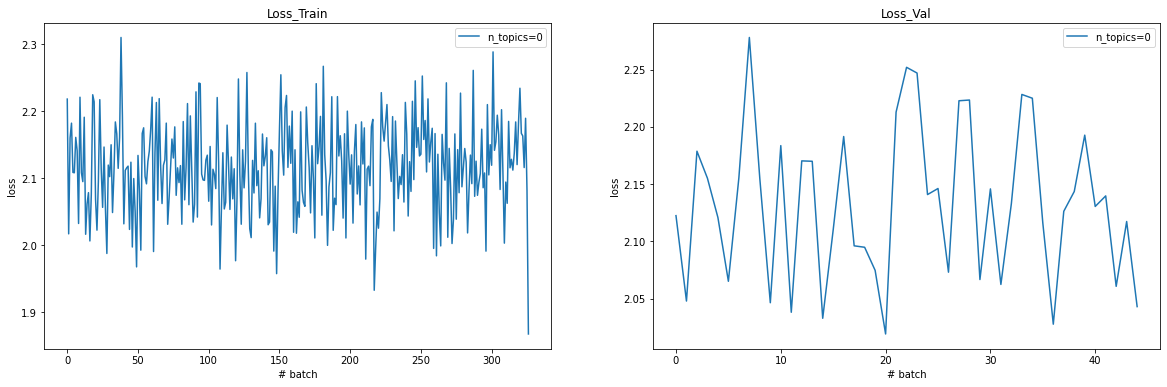

In [48]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,2,j+1)
  for i in range(len(df)):
    y = df[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

The t=90 model performing well as the one in the article.  
<br><br><br>

Thanks For Reading... :))